## Multimodal Training Baseline

Pipeline for loading and preprocessing data, training model and evaluating

In [1]:
import os
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_ # modifies the tensors in-place (vs clip_grad_norm)
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

pd.set_option("display.max_columns", None)
np.random.seed(42)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import sys
sys.path.append('./BGR')
import bgr.soil.datasets as bgr_data
import bgr.soil.models as bgr_mod
from bgr.soil.callbacks import EarlyStopping
from bgr.soil.metrics import top_k_accuracy, TopKLoss

In [3]:
path_csv = "../data/BGR/data_horizons.csv"
path_csv_annotator_ids = '../data/BGR/Kartierer_ID.csv'
path_csv_locations = '../data/BGR/STANDORT.csv'
path_horizons_simple = '../data/BGR/Vereinfachung_Horizontsymbole.csv'
#path_pictures = "../data/BGR/Profilbilder_no_ruler_no_sky/"
path_pictures = "../data/BGR/Horizonte/"

### Data Loading

In [4]:
df = pd.read_csv(path_csv)
print(len(df.index))
df = df.dropna(subset=['Horizontsymbol'])
print(len(df.index))
df#.head()

15207
15206


,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Unnamed: 11,Bundesland,PointID,Unnamed: 14,profile,max_depth
0,2.0,1.0,0.0,28.0,I; Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,NaN,SH,2.0,NaN,BB_0541.0,100.0
1,2.0,2.0,28.0,54.0,I; E,Sl2,10YR 3/3,3.0,C0,h2,Wf3,NaN,SH,3.0,NaN,BB_0600.0,90.0
2,2.0,3.0,54.0,68.0,II; Bv,Sl2,7.5YR 4/3,10.0,C0,h1,Wf3,NaN,SH,4.0,NaN,BB_0601.0,100.0
3,2.0,4.0,68.0,96.0,III; Bv-ilCv,fSms,7.5YR 6/4,1.0,C0,h0,Wf2,NaN,SH,5.0,NaN,BB_0659.0,100.0
4,2.0,5.0,96.0,201.0,III; ilCv,mSfs,10YR 7/4,1.0,C0,h0,NaN,NaN,SH,6.0,NaN,BB_0660.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15201,6211.0,3.0,27.0,50.0,I; Bbh+Bs,fSms,5YR 3/2,1.0,C0,h2,Wf3,NaN,NaN,NaN,NaN,NaN,NaN
15202,6211.0,4.0,50.0,70.0,I; Bbs+Bs,fSms,5YR 4/3,1.0,C0,h1,Wf2,NaN,NaN,NaN,NaN,NaN,NaN
15203,6211.0,5.0,70.0,100.0,I; Go-Bbs,fSms,7.5YR 5/4,1.0,C0,h1,Wf6,NaN,NaN,NaN,NaN,NaN,NaN
15204,6211.0,6.0,100.0,130.0,I; Go,fSms,2.5Y 6/4,1.0,C0,h0,Wf4,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_simple = pd.read_csv(path_horizons_simple)
df_simple.rename(columns={"relevanter Anteil = was sinntragend und detektierbar ist - es sind nicht alles gültige Symbole": "relevanter Anteil"}, inplace=True)
df_simple.head()

,Horiz,Anzahl im Datensatz,relevanter Anteil,stark vereinfacht
0,Ap,1762,Ap,Ap
1,Bv,626,Bv,Bv
2,ilCv,620,ilC,Cv
3,elCv,500,elC,Cv
4,Ah,455,Ah,Ah


In [6]:
# Add an extra column to the original dataset with the simplified horizon symbols

# Apply the simplification function to each row of the 'Horizontsymbol' column
col_name = "relevanter Anteil" # try to predict 'relevanter Anteil' first; otherwise, resort to 'stark vereinfacht'
df['Horizontsymbol_relevant'] = df['Horizontsymbol'].apply(lambda x: bgr_data.simplify_string(x, df_simple, col_name))

# Reorder the columns
cols = df.columns.tolist()
cols.insert(cols.index('Horizontsymbol') + 1, 'Horizontsymbol_relevant')
cols.pop() # remove the duplicate at the end
df = df[cols]
df

,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Horizontsymbol_relevant,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Unnamed: 11,Bundesland,PointID,Unnamed: 14,profile,max_depth
0,2.0,1.0,0.0,28.0,I; Ap,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,NaN,SH,2.0,NaN,BB_0541.0,100.0
1,2.0,2.0,28.0,54.0,I; E,E,Sl2,10YR 3/3,3.0,C0,h2,Wf3,NaN,SH,3.0,NaN,BB_0600.0,90.0
2,2.0,3.0,54.0,68.0,II; Bv,Bv,Sl2,7.5YR 4/3,10.0,C0,h1,Wf3,NaN,SH,4.0,NaN,BB_0601.0,100.0
3,2.0,4.0,68.0,96.0,III; Bv-ilCv,Bv-ilC,fSms,7.5YR 6/4,1.0,C0,h0,Wf2,NaN,SH,5.0,NaN,BB_0659.0,100.0
4,2.0,5.0,96.0,201.0,III; ilCv,ilC,mSfs,10YR 7/4,1.0,C0,h0,NaN,NaN,SH,6.0,NaN,BB_0660.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15201,6211.0,3.0,27.0,50.0,I; Bbh+Bs,Bbh+Bs,fSms,5YR 3/2,1.0,C0,h2,Wf3,NaN,NaN,NaN,NaN,NaN,NaN
15202,6211.0,4.0,50.0,70.0,I; Bbs+Bs,Bbs+Bs,fSms,5YR 4/3,1.0,C0,h1,Wf2,NaN,NaN,NaN,NaN,NaN,NaN
15203,6211.0,5.0,70.0,100.0,I; Go-Bbs,Go-Bbs,fSms,7.5YR 5/4,1.0,C0,h1,Wf6,NaN,NaN,NaN,NaN,NaN,NaN
15204,6211.0,6.0,100.0,130.0,I; Go,Go,fSms,2.5Y 6/4,1.0,C0,h0,Wf4,NaN,NaN,NaN,NaN,NaN,NaN


#### ngram-embedding and clustering of labels

In [7]:
label_texts = list(df['Horizontsymbol_relevant'].unique())
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(4, 4))
label_vectors = vectorizer.fit_transform(label_texts)
label_vectors

<1668x1514 sparse matrix of type '<class 'numpy.float64'>'
	with 4836 stored elements in Compressed Sparse Row format>

In [8]:
vectorizer.vocabulary_

{'bv-i': 434,
 'v-il': 1409,
 '-ilc': 163,
 'tsw-': 1343,
 'sw-a': 1279,
 'w-ah': 1438,
 'w-ap': 1440,
 'tgo-': 1331,
 'go-s': 723,
 'o-sw': 1063,
 'o-sd': 1059,
 'tgor': 1332,
 'sw-t': 1290,
 'w-ta': 1462,
 '-tap': 195,
 'tgro': 1335,
 'bsh°': 389,
 'sh°g': 1253,
 'h°go': 864,
 'bs°g': 395,
 's°go': 1296,
 'r-ah': 1134,
 'r+gs': 1121,
 '+gso': 55,
 'gso+': 744,
 'so+g': 1254,
 'o+gr': 1023,
 'r+gr': 1120,
 '+gr+': 52,
 'gr+g': 732,
 'r+go': 1119,
 '+go+': 50,
 'go+g': 710,
 'o+gs': 1024,
 'agr1': 263,
 'agr2': 264,
 'tbsq': 1329,
 'bsq1': 391,
 'bsq2': 392,
 'tap-': 1326,
 'ap-g': 315,
 'p-go': 1093,
 'ah+i': 273,
 'h+il': 772,
 '+ilc': 65,
 'ilcv': 877,
 'aeh°': 242,
 'eh°g': 622,
 's°gw': 1298,
 'go-b': 715,
 'o-bh': 1037,
 '-bhs': 111,
 'bs-g': 383,
 's-go': 1203,
 '-go1': 150,
 '-go2': 151,
 'go-a': 714,
 'o-ap': 1034,
 'ilc+': 870,
 'lc+b': 938,
 'c+bs': 452,
 '+bsh': 26,
 'bsh+': 386,
 'sh+b': 1249,
 'h+bs': 760,
 'bhs+': 360,
 'hs+i': 829,
 's+il': 1193,
 'fnhr': 667,
 'nhr1': 

In [9]:
print(label_vectors)

  (3, 434)	0.6360065699403734
  (3, 1409)	0.6105368760638713
  (3, 163)	0.47195377523529763
  (5, 1343)	0.651025426772731
  (5, 1279)	0.48140494560049996
  (5, 1438)	0.5868689564517474
  (6, 1343)	0.6463054098749298
  (6, 1279)	0.4779146987000319
  (6, 1440)	0.5948839029027906
  (7, 1331)	0.6147557490196333
  (7, 723)	0.547550696625837
  (7, 1063)	0.5676826610632653
  (8, 1331)	0.5825129190473709
  (8, 723)	0.518832650408856
  (8, 1059)	0.6256927201211733
  (9, 1332)	1.0
  (11, 1290)	0.5566166840251662
  (11, 1462)	0.5874427065956425
  (11, 195)	0.5874427065956425
  (13, 1335)	1.0
  (19, 389)	0.6060711285719074
  (19, 1253)	0.6060711285719074
  (19, 864)	0.515126755491451
  (20, 395)	0.6927969192276785
  (20, 1296)	0.7211327400060529
  :	:
  (1661, 225)	0.4279145653851226
  (1661, 299)	0.4965593438297426
  (1661, 928)	0.5788629124775555
  (1662, 403)	0.5189302517233415
  (1662, 87)	0.47764299781932484
  (1662, 225)	0.4214139376004024
  (1662, 1310)	0.5700691656953935
  (1663, 944)	0.68

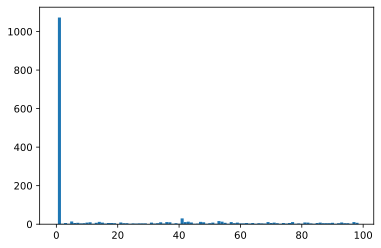

In [10]:
k = 100
kmeans = KMeans(n_clusters=k, random_state=2024)
label_clusters = kmeans.fit_predict(label_vectors)
plt.hist(label_clusters, bins = np.arange(k)-0.5)
plt.show()

In [11]:
label_to_cluster = {label: cluster for label, cluster in zip(label_texts, label_clusters)}
label_to_cluster

{'Ap': 1,
 'E': 1,
 'Bv': 1,
 'Bv-ilC': 57,
 'ilC': 1,
 'tSw-Ah': 1,
 'tSw-Ap': 1,
 'tGo-Sw': 77,
 'tGo-Sd': 99,
 'tGor': 1,
 'tGr': 1,
 'Sw-tAp': 1,
 'tSq': 1,
 'tGro': 1,
 'Aeh': 1,
 'Aep': 1,
 'oCv': 1,
 'fOh': 1,
 'Ae': 1,
 'Bsh°Go': 82,
 'Bs°Go': 1,
 'R-Ah': 1,
 'R+Gso+Gr': 1,
 'R+Gr+Gso': 1,
 'R+Go+Gso': 53,
 'aGr1': 1,
 'aGr2': 1,
 'tbSq1': 1,
 'tbSq2': 1,
 'Hr': 1,
 'tAp-Go': 80,
 'Ah+ilCv': 85,
 'Aeh°Go': 82,
 'Bs°Gw': 1,
 'Gr': 1,
 'Go-Bhs': 1,
 'Bs-Go1': 9,
 'Bs-Go2': 9,
 'Gor': 1,
 'Go-Ap': 1,
 'Go': 1,
 'Gw': 1,
 'oGr': 1,
 'ilC+Bsh+Bs': 27,
 'Bhs+ilC': 26,
 'M': 1,
 'Ah': 1,
 'Sd': 1,
 'tAp': 1,
 'tGo': 1,
 'Hw': 1,
 'fnHr1': 1,
 'fnHr2': 1,
 'tmGr1': 1,
 'tmGr2': 1,
 'tGo-Ap': 1,
 'Gro': 1,
 'Bh-Gw': 1,
 'Bhs-Bs': 1,
 'Bhs-Go1': 88,
 'Bhs-Go2': 88,
 'Bhs': 1,
 'Sw-Bs': 1,
 'Sw': 1,
 'Sd1': 1,
 'Sd2': 1,
 'Ap+Al': 1,
 'Bt-Sd': 97,
 'Sd-ilC': 15,
 'Al-Sw': 31,
 'lC': 1,
 'Swd1': 1,
 'Swd2': 70,
 'ilC-Sd': 22,
 'elCv-Sd1': 36,
 'elCv-Sd2': 36,
 'Bh-Aeh': 1,
 'Bsh': 1,
 'Bs'

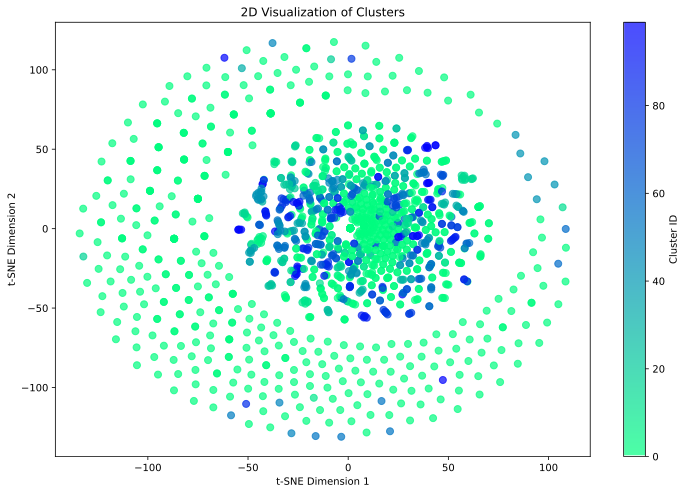

In [12]:
# Reduce dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=2024)
label_vectors_2d = tsne.fit_transform(label_vectors.toarray())  # Convert sparse matrix to dense

# Create a DataFrame for visualization
visualization_df = pd.DataFrame({
    'x': label_vectors_2d[:, 0],
    'y': label_vectors_2d[:, 1],
    'Cluster': label_clusters  # Cluster IDs from k-means
})

# Plot the clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    visualization_df['x'],
    visualization_df['y'],
    c=visualization_df['Cluster'],
    cmap='winter_r',  # Use a colormap
    s=50,          # Marker size
    alpha=0.7      # Transparency
)
plt.colorbar(scatter, label='Cluster ID')
plt.title("2D Visualization of Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

In [13]:
# Map the original labels to cluster labels
df['Horizont_cluster'] = df['Horizontsymbol_relevant'].map(label_to_cluster)
df.head()

/tmp/ipykernel_288468/2090476320.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Horizont_cluster'] = df['Horizontsymbol_relevant'].map(label_to_cluster)


,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Horizontsymbol_relevant,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Unnamed: 11,Bundesland,PointID,Unnamed: 14,profile,max_depth,Horizont_cluster
0,2.0,1.0,0.0,28.0,I; Ap,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,NaN,SH,2.0,NaN,BB_0541.0,100.0,1
1,2.0,2.0,28.0,54.0,I; E,E,Sl2,10YR 3/3,3.0,C0,h2,Wf3,NaN,SH,3.0,NaN,BB_0600.0,90.0,1
2,2.0,3.0,54.0,68.0,II; Bv,Bv,Sl2,7.5YR 4/3,10.0,C0,h1,Wf3,NaN,SH,4.0,NaN,BB_0601.0,100.0,1
3,2.0,4.0,68.0,96.0,III; Bv-ilCv,Bv-ilC,fSms,7.5YR 6/4,1.0,C0,h0,Wf2,NaN,SH,5.0,NaN,BB_0659.0,100.0,57
4,2.0,5.0,96.0,201.0,III; ilCv,ilC,mSfs,10YR 7/4,1.0,C0,h0,NaN,NaN,SH,6.0,NaN,BB_0660.0,100.0,1


#### Join images and further tables

In [14]:
image_dataset = os.listdir(path_pictures)
img_files = pd.DataFrame(image_dataset, columns=['file'])
img_files['Point'] = img_files['file'].str.split("_").map(lambda x: x[1]).astype(float)
img_files['HorizontID'] = img_files['file'].str.split('.').map(lambda x: x[0][-1]).astype(float)
img_files.head(15)

,file,Point,HorizontID
0,BB_0723_Y_1_hor1.JPG,723.0,1.0
1,BB_0723_Y_1_hor2.JPG,723.0,2.0
2,BB_0723_Y_1_hor3.JPG,723.0,3.0
3,BB_0723_Y_1_hor4.JPG,723.0,4.0
4,BB_0723_Y_1_hor5.JPG,723.0,5.0
5,BB_0541_Y_1_hor1.JPG,541.0,1.0
6,BB_0541_Y_1_hor2.JPG,541.0,2.0
7,BB_0541_Y_1_hor3.JPG,541.0,3.0
8,BB_0541_Y_1_hor4.JPG,541.0,4.0
9,BB_0725_Y_1_hor1.JPG,725.0,1.0


In [15]:
#df = pd.merge(df, img_files, how='inner', on=['Point'])
df = pd.merge(df, img_files, how='inner', on=['Point', 'HorizontID'])
df['file'] = df['file'].map(lambda x: os.path.join(path_pictures, x))
df.head(15)

,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Horizontsymbol_relevant,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Unnamed: 11,Bundesland,PointID,Unnamed: 14,profile,max_depth,Horizont_cluster,file
0,2.0,1.0,0.0,28.0,I; Ap,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,NaN,SH,2.0,NaN,BB_0541.0,100.0,1,../data/BGR/Horizonte/SH_0002_Y_1_hor1.JPG
1,2.0,2.0,28.0,54.0,I; E,E,Sl2,10YR 3/3,3.0,C0,h2,Wf3,NaN,SH,3.0,NaN,BB_0600.0,90.0,1,../data/BGR/Horizonte/SH_0002_Y_1_hor2.JPG
2,2.0,3.0,54.0,68.0,II; Bv,Bv,Sl2,7.5YR 4/3,10.0,C0,h1,Wf3,NaN,SH,4.0,NaN,BB_0601.0,100.0,1,../data/BGR/Horizonte/SH_0002_Y_1_hor3.JPG
3,2.0,4.0,68.0,96.0,III; Bv-ilCv,Bv-ilC,fSms,7.5YR 6/4,1.0,C0,h0,Wf2,NaN,SH,5.0,NaN,BB_0659.0,100.0,57,../data/BGR/Horizonte/SH_0002_Y_1_hor4.JPG
4,2.0,5.0,96.0,201.0,III; ilCv,ilC,mSfs,10YR 7/4,1.0,C0,h0,NaN,NaN,SH,6.0,NaN,BB_0660.0,100.0,1,../data/BGR/Horizonte/SH_0002_Y_1_hor5.JPG
5,3.0,1.0,0.0,12.0,I; tbSw-Ah,tSw-Ah,Ls3,10YR 4/2,0.0,C0,h3,Wf6,NaN,SH,7.0,NaN,BB_0661.0,100.0,1,../data/BGR/Horizonte/SH_0003_Y_1_hor1.JPG
6,3.0,2.0,12.0,30.0,I; tbSw-rAp,tSw-Ap,Ls2,10YR 4/2,0.0,C0,h2,Wf4,NaN,SH,8.0,NaN,BB_0662.0,100.0,1,../data/BGR/Horizonte/SH_0003_Y_1_hor2.JPG
7,3.0,3.0,30.0,54.0,I; tbrGo-Sw,tGo-Sw,Ls4,2.5Y 5/1,0.0,C0,h1,Wf2,NaN,SH,10.0,NaN,BB_0663.0,100.0,77,../data/BGR/Horizonte/SH_0003_Y_1_hor3.JPG
8,3.0,4.0,54.0,125.0,I; tbGo-Sd,tGo-Sd,Lu,5Y 5/1,0.0,C0,h1,NaN,NaN,SH,11.0,NaN,BB_0718.0,100.0,99,../data/BGR/Horizonte/SH_0003_Y_1_hor4.JPG
9,4.0,1.0,0.0,30.0,I; Sw-tbAp,Sw-tAp,Tu3,5Y 5/2,0.0,C0,h3,Wf4,NaN,SH,15.0,NaN,BB_0722.0,100.0,1,../data/BGR/Horizonte/SH_0004_Y_1_hor1.JPG


In [16]:
df_k = pd.read_csv(path_csv_annotator_ids)
df_k = df_k.rename({'PointID':'Point'},axis=1)
df_k.head()

,Point,Aufnehmer
0,2,Kart8
1,3,Kart8
2,4,Kart10
3,5,Kart8
4,6,Kart8


In [17]:
df_loc = pd.read_csv(path_csv_locations, encoding='unicode_escape')
df_loc = df_loc.rename({'PointID':'Point'},axis=1)
df_loc.head()

,Point,Bundesland,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
0,2,SH,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,>200,0.0,0.0,N0,NaN,GG,V,Z,81.89,54.19
1,3,SH,6,2016,480546.9384,6079739.216,Marsch - Nord,G,0,MD,MDn,GWS4,135,0.0,0.0,N0,NaN,GG,TSF,Z,71.62,59.74
2,4,SH,8,2018,484922.3074,6080011.471,Marsch - Nord,A,0,MK,MKn,GWS4,105,0.0,0.0,N1,NE,GG,TH,Z,65.60,120.40
3,5,SH,10,2015,497355.9905,6079646.589,Marsch - Nord,G,0,RQ,p2RQ/GG-PP,GWS4,180,0.0,0.0,N0.2,SS,GG,KSF,K,88.82,220.87
4,6,SH,10,2015,505020.3377,6080401.37,Geest - Nord,G,0,YU,aGGe-YU,GWS4,140,0.0,0.0,N0,NaN,GG,TSF,Z,62.97,84.35


In [18]:
df = pd.merge(df, df_k, how='inner', on='Point')

In [19]:
df_loc['Point'] = pd.to_numeric(df['Point'])
df = pd.merge(df, df_loc, how='inner', on='Point')

In [20]:
df[df['ycoord']=='N0'] # invalid ycoord?

,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Horizontsymbol_relevant,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Unnamed: 11,Bundesland_x,PointID,Unnamed: 14,profile,max_depth,Horizont_cluster,file,Aufnehmer,Bundesland_y,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
551,32.0,1.0,0.0,10.0,I; Ah,Ah,Ls3,10YR 3/3,3.0,C0,h3,Wf6,NaN,MV,215.0,NaN,BB_1716.0,100.0,1,../data/BGR/Horizonte/SH_0032_Y_1_hor1.JPG,Kart8,GWS3,120,0,0.0,N0,NaN,GG,TS,Z,159.95,118.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
556,32.0,2.0,10.0,28.0,I; rAp,Ap,Ls3,2.5Y 5/3,3.0,C0,h3,Wf4,NaN,SH,218.0,NaN,BB_1722.0,100.0,1,../data/BGR/Horizonte/SH_0032_Y_1_hor2.JPG,Kart8,GWS3,120,0,0.0,N0,NaN,GG,TS,Z,159.95,118.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
561,32.0,3.0,28.0,46.0,II; Bv-Sdw,Bv-Sw,Ls3,2.5Y 5/2,5.0,C0,h1,Wf3,NaN,SH,219.0,NaN,BB_1723.0,100.0,5,../data/BGR/Horizonte/SH_0032_Y_1_hor3.JPG,Kart8,GWS3,120,0,0.0,N0,NaN,GG,TS,Z,159.95,118.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
566,32.0,4.0,46.0,85.0,II; Sd,Sd,Ls3,2.5Y 5/2,3.0,C0,h0,Wf1,NaN,SH,220.0,NaN,BB_1725.0,100.0,1,../data/BGR/Horizonte/SH_0032_Y_1_hor4.JPG,Kart8,GWS3,120,0,0.0,N0,NaN,GG,TS,Z,159.95,118.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
571,32.0,5.0,85.0,201.0,III; eSd,Sd,Ls3,2.5Y 5/3,3.0,C3.4,h0,Wf0,NaN,SH,221.0,NaN,BB_1726.0,100.0,1,../data/BGR/Horizonte/SH_0032_Y_1_hor5.JPG,Kart8,GWS3,120,0,0.0,N0,NaN,GG,TS,Z,159.95,118.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,229.0,1.0,0.0,10.0,I; rnHm,Hm,Ha,10YR 2/1,2.0,C0,h7,Wf6,NaN,NI,1618.0,NaN,BY_5042.0,100.0,1,../data/BGR/Horizonte/SH_0229_Y_1_hor1.JPG,Kart8,GWS4,110,42,24.0,N0,NaN,GG,TS,Z,251.99,84.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3082,229.0,2.0,10.0,34.0,I; rnHa,Ha,Ha,10YR 2/1,2.0,C0,h7,Wf3,NaN,NI,1619.0,NaN,BY_5043.0,100.0,1,../data/BGR/Horizonte/SH_0229_Y_1_hor2.JPG,Kart8,GWS4,110,42,24.0,N0,NaN,GG,TS,Z,251.99,84.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3087,229.0,3.0,34.0,53.0,II; Gw1,Gw1,mSfs,10YR 5/2,0.0,C0,h1,Wf0,NaN,NI,1620.0,NaN,BY_5046.0,100.0,1,../data/BGR/Horizonte/SH_0229_Y_1_hor3.JPG,Kart8,GWS4,110,42,24.0,N0,NaN,GG,TS,Z,251.99,84.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3092,229.0,4.0,53.0,70.0,II; Gw2,Gw2,mSfs,2.5YR 5/1,0.0,C0,h0,Wf0,NaN,NI,1622.0,NaN,BY_5047.0,100.0,1,../data/BGR/Horizonte/SH_0229_Y_1_hor4.JPG,Kart8,GWS4,110,42,24.0,N0,NaN,GG,TS,Z,251.99,84.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3097,229.0,5.0,70.0,201.0,II; Gr,Gr,fS,5Y 6/1,0.0,C0,h0,Wf0,NaN,NI,1627.0,NaN,BY_5048.0,100.0,1,../data/BGR/Horizonte/SH_0229_Y_1_hor5.JPG,Kart8,GWS4,110,42,24.0,N0,NaN,GG,TS,Z,251.99,84.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df = df[df['ycoord'] != 'N0']
len(df)

14168

In [22]:
keep_columns = ['Point', 'HorizontID', 'Obergrenze', 'Untergrenze',
                #'Horizontsymbol',
                #'Horizontsymbol_relevant',
                'Horizont_cluster', 'Bodenart', 'Bodenfarbe', 'Steine', 'Karbonat', 'Humusgehaltsklasse', 'Durchwurzelung',
                'max_depth', 'file', 'Aufnehmer', 'Probenahme_Monat', 'Probenahme_Jahr', 'xcoord', 'ycoord', 'Bodenklimaraum_Name',
                'Landnutzung', 'BZE_Moor', 'Hauptbodentyp', 'BodenVarTypSub', 'GrundwaStufe', 'GrundwaStand', 'Moormaechtigkeit',
                'Torfmaechtigkeit', 'Neigung', 'Exposition', 'Woelbung', 'Reliefformtyp', 'LageImRelief', 'KV_0_30', 'KV_30_100']
df = df[keep_columns]
df['GrundwaStand'] = df['GrundwaStand'].str.replace('>','').astype(float)
df

,Point,HorizontID,Obergrenze,Untergrenze,Horizont_cluster,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,max_depth,file,Aufnehmer,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
0,2.0,1.0,0.0,28.0,1,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,100.0,../data/BGR/Horizonte/SH_0002_Y_1_hor1.JPG,Kart8,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,200.0,0.0,0.0,N0,NaN,GG,V,Z,81.89,54.19
1,2.0,1.0,0.0,28.0,1,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,100.0,../data/BGR/Horizonte/SH_0002_Y_1_hor1.JPG,Kart8,6,2016,480546.9384,6079739.216,Marsch - Nord,G,0,MD,MDn,GWS4,135.0,0.0,0.0,N0,NaN,GG,TSF,Z,71.62,59.74
2,2.0,1.0,0.0,28.0,1,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,100.0,../data/BGR/Horizonte/SH_0002_Y_1_hor1.JPG,Kart8,8,2018,484922.3074,6080011.471,Marsch - Nord,A,0,MK,MKn,GWS4,105.0,0.0,0.0,N1,NE,GG,TH,Z,65.60,120.40
3,2.0,1.0,0.0,28.0,1,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,100.0,../data/BGR/Horizonte/SH_0002_Y_1_hor1.JPG,Kart8,10,2015,497355.9905,6079646.589,Marsch - Nord,G,0,RQ,p2RQ/GG-PP,GWS4,180.0,0.0,0.0,N0.2,SS,GG,KSF,K,88.82,220.87
4,2.0,1.0,0.0,28.0,1,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,100.0,../data/BGR/Horizonte/SH_0002_Y_1_hor1.JPG,Kart8,10,2015,505020.3377,6080401.37,Geest - Nord,G,0,YU,aGGe-YU,GWS4,140.0,0.0,0.0,N0,NaN,GG,TSF,Z,62.97,84.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14173,1480.0,3.0,88.0,120.0,1,Us,GLEY1 6/5GY,0.0,C3,h1,Wf0,NaN,../data/BGR/Horizonte/NW_1480_Y_1_hor3.JPG,Kart10,10,2011,448236.4426,5454486.16,Rheinebene und Nebentäler,A,0,TC,vLL-TC,0,200.0,0.0,0.0,N0.1,NaN,XX,V,Z,37.83,41.80
14174,1480.0,3.0,88.0,120.0,1,Us,GLEY1 6/5GY,0.0,C3,h1,Wf0,NaN,../data/BGR/Horizonte/NW_1480_Y_1_hor3.JPG,Kart10,11,2011,450265.8395,5448367.068,Rheinebene und Nebentäler,A,0,YK,YKn,0,200.0,0.0,0.0,N1,EE,XV,T,Z,38.99,47.26
14175,1484.0,1.0,0.0,27.0,1,Su4,10YR 3/2,2.0,C0,h4,Wf3,NaN,../data/BGR/Horizonte/NW_1484_Y_1_hor1.JPG,Kart10,6,2012,522076.9633,5930456.114,Elbe-Weser-Dreieck / sandige Böden,G,0,PP,GG-PP,GWS4,110.0,0.0,0.0,N0,NaN,GG,TSF,T,117.59,87.72
14176,1484.0,2.0,27.0,54.0,1,Us,5Y 7/1,10.0,C0,h1,Wf2,NaN,../data/BGR/Horizonte/NW_1484_Y_1_hor2.JPG,Kart10,6,2012,522076.9633,5930456.114,Elbe-Weser-Dreieck / sandige Böden,G,0,PP,GG-PP,GWS4,110.0,0.0,0.0,N0,NaN,GG,TSF,T,117.59,87.72


In [23]:
# Profile images only show horizons up to ~1 meter depth
# Note: Filter only necessary when joining table with whole images, not horizon segments
df = df[df['Obergrenze'] <= 100]
len(df)

14168

#### Imputation

In [24]:
df['Steine'] = df['Steine'].fillna(0.0)
df['Durchwurzelung'] = df['Durchwurzelung'].fillna('Wf0')
df['Durchwurzelung'] = df['Durchwurzelung'].str.split(',').str[0] # Some values have double labels; only keep the first one
df['Exposition'] = df['Exposition'].replace(['0', '---'], 'KE') # KE = Keine
df.loc[df['Exposition'].isna() & (df['Neigung'] == 'N0'), 'Exposition'] = 'KE' # NaN-Exposition should be 'KE', when Neigung is N0 (there will still be some other NaNs in Exposition

In [25]:
df = df.dropna()
len(df)

7901

#### One-hot encoding

In [26]:
target = 'Horizont_cluster' #'Horizontsymbol_relevant'
num_features   = ['xcoord','ycoord', 'Steine', 'Probenahme_Monat', 'Probenahme_Jahr', 'GrundwaStand', 'Moormaechtigkeit', 'Torfmaechtigkeit', 'KV_0_30', 'KV_30_100']
categ_features = ['Bodenart', 'Bodenfarbe', 'Karbonat', 'Humusgehaltsklasse', 'Durchwurzelung', 'Bodenklimaraum_Name',
                  'Landnutzung', 'BZE_Moor', 'Hauptbodentyp', 'BodenVarTypSub', 'GrundwaStufe', 'Neigung',
                  'Exposition', 'Woelbung', 'Reliefformtyp', 'LageImRelief']
feature_columns = num_features + categ_features

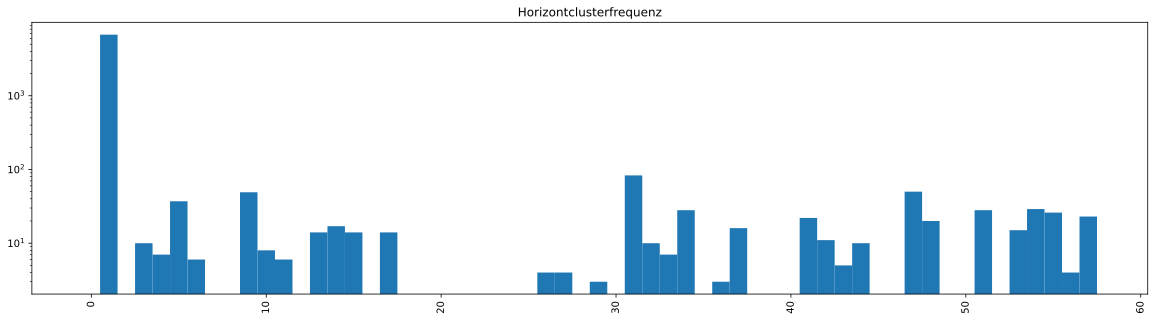

In [27]:
counts = df[target].value_counts()
plt.figure(figsize=(20, 5))
plt.hist(df[target], bins = np.arange(len(counts))-0.5, log=True)
plt.title('Horizontclusterfrequenz')
plt.xticks(rotation='vertical')
#plt.xticks([])
plt.show()

In [28]:
counts

Horizont_cluster
1     6735
97     121
98      89
31      83
47      50
9       49
64      48
5       37
77      33
93      30
54      29
58      29
51      28
34      28
88      27
55      26
87      25
82      24
57      23
41      22
70      21
48      20
99      18
14      17
37      16
69      16
53      15
13      14
90      14
15      14
17      14
86      12
42      11
32      10
74      10
3       10
44      10
66      10
80      10
10       8
62       7
4        7
60       7
33       7
81       7
6        6
11       6
85       6
43       5
91       4
71       4
26       4
78       4
56       4
95       4
27       4
29       3
36       3
79       3
Name: count, dtype: int64

In [29]:
# Filter out for most frequent symbols
#keep_horiz_symb = counts[(900 > counts) & (counts >= 50)].index
#keep_horiz_symb = counts[counts >= 50].index
keep_horiz_symb = counts[counts >= 10].index
keep_horiz_symb

Index([ 1, 97, 98, 31, 47,  9, 64,  5, 77, 93, 54, 58, 51, 34, 88, 55, 87, 82,
       57, 41, 70, 48, 99, 14, 37, 69, 53, 13, 90, 15, 17, 86, 42, 32, 74,  3,
       44, 66, 80],
      dtype='int32', name='Horizont_cluster')

In [30]:
len(keep_horiz_symb)

39

In [31]:
df = df[df['Horizont_cluster'].isin(keep_horiz_symb)]
len(df)

7798

In [32]:
### Downsample the dominant label
most_common_label_df = df[df['Horizont_cluster'] == counts.idxmax()]

# Randomly sample 100 rows
sampled_df = most_common_label_df.sample(n=200, random_state=2024)

# Combine the sampled rows with the rest of the DataFrame
reduced_df = pd.concat([
    sampled_df,
    df[df['Horizont_cluster'] != counts.idxmax()]
])

# Reset the index (optional)
df = reduced_df.reset_index(drop=True)
len(df)

1263

In [33]:
# Encode label vector
bgr_data.encode_categorical_columns(df, target)
df[target] = df[target].astype(int)

In [34]:
for categ in categ_features:
    bgr_data.encode_categorical_columns(df, categ)
df

/mnt/KInsektDaten/teo/./BGR/bgr/soil/datasets.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col_name] = df[col_name].replace(counts.index, range(len(counts)))
/mnt/KInsektDaten/teo/./BGR/bgr/soil/datasets.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col_name] = df[col_name].replace(counts.index, range(len(counts)))
/mnt/KInsektDaten/teo/./BGR/bgr/soil/datasets.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly ca

,Point,HorizontID,Obergrenze,Untergrenze,Horizont_cluster,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,max_depth,file,Aufnehmer,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
0,507.0,3.0,33.0,50.0,0,20,44,0.0,0,2,3,70.0,../data/BGR/Horizonte/SH_0507_Y_1_hor3.JPG,Kart8,4,2013,515519.3276,5690717.157,24,0,0,8,3,0,200.0,0.0,0.0,2,7,7,4,2,66.15,18.94
1,91.0,2.0,30.0,40.0,0,6,3,3.0,0,2,2,100.0,../data/BGR/Horizonte/MV_0091_Y_1_hor2.JPG,Kart8,5,2012,831485.2269,5956297.501,25,1,1,9,402,2,60.0,120.0,100.0,0,0,0,2,0,184.49,409.19
2,944.0,3.0,33.0,54.0,0,2,77,2.0,0,1,3,80.0,../data/BGR/Horizonte/BB_0944_Y_1_hor3.JPG,Kart8,7,2014,727446.5138,5483410.797,26,0,0,0,71,0,200.0,0.0,0.0,5,5,3,4,1,42.33,8.85
3,308.0,3.0,53.0,73.0,0,1,15,3.0,0,0,3,100.0,../data/BGR/Horizonte/SH_0308_Y_1_hor3.JPG,Kart8,3,2014,693673.6506,5794569.842,0,0,0,1,12,1,110.0,0.0,0.0,0,0,0,6,0,137.94,82.68
4,551.0,3.0,60.0,74.0,0,2,38,1.0,0,2,3,100.0,../data/BGR/Horizonte/NI_0551_Y_1_hor3.JPG,Kart10,2,2015,644943.0796,5673007.103,2,0,0,8,3,0,200.0,0.0,0.0,3,2,0,0,1,74.82,20.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258,905.0,3.0,50.0,74.0,16,4,36,3.0,0,1,0,100.0,../data/BGR/Horizonte/BB_0905_Y_1_hor3.JPG,Kart10,5,2015,560396.3500,5488634.729,15,0,0,2,4,0,200.0,0.0,0.0,2,3,0,0,4,43.40,36.68
1259,905.0,3.0,50.0,74.0,16,4,36,3.0,0,1,0,100.0,../data/BGR/Horizonte/BB_0905_Y_1_hor3.JPG,Kart10,11,2014,569313.5938,5489932.003,15,0,0,15,162,0,200.0,0.0,0.0,2,7,1,0,1,53.69,42.45
1260,922.0,2.0,13.0,50.0,17,1,67,0.0,0,6,0,100.0,../data/BGR/Horizonte/NI_0922_Y_1_hor2.JPG,Kart8,3,2012,392610.1211,5480913.736,35,0,0,9,286,4,105.0,0.0,0.0,3,1,0,5,2,48.24,55.41
1261,922.0,2.0,13.0,50.0,17,1,67,0.0,0,6,0,100.0,../data/BGR/Horizonte/NI_0922_Y_1_hor2.JPG,Kart8,11,2011,439457.5729,5480008.1,35,2,0,20,415,0,200.0,0.0,0.0,3,5,4,0,4,50.61,52.98


### Training

In [35]:
# Define the image normalization
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize with ImageNet statistics
])

In [36]:
# Initialize model
vision_backbone = 'WinKawaks/vit-small-patch16-224' # https://huggingface.co/WinKawaks/vit-small-patch16-224/tree/main
model = bgr_mod.ImageTabularModel(vision_backbone=vision_backbone,
                                  num_tabular_features=len(feature_columns),
                                  num_classes=len(df[target].unique()))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of the model checkpoint at WinKawaks/vit-small-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ImageTabularModel(
  (vision_backbone): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=384, 

In [37]:
# Data split
train_df, val_df = train_test_split(df, stratify=df[target], random_state=2024)

print(f'{len(train_df)} samples for training.')
print(f'{len(val_df)} samples for validating.')

947 samples for training.
316 samples for validating.


In [38]:
# Define the image transforms for augmentation
augment = [
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(1., 3.))
]

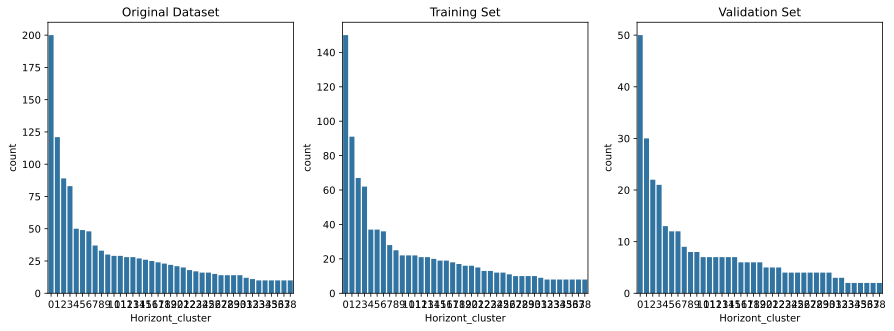

In [39]:
# Visualize the distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.countplot(x=target, data=df, ax=axes[0])
axes[0].set_title('Original Dataset'); #axes[0].set_xticklabels([])

sns.countplot(x=target, data=train_df, ax=axes[1])
axes[1].set_title('Training Set'); #axes[1].set_xticklabels([])

sns.countplot(x=target, data=val_df, ax=axes[2])
axes[2].set_title('Validation Set'); #axes[2].set_xticklabels([])

plt.show()

In [40]:
# Erstelle das Dataset mit DataFrame, Bildern und tabellarischen Daten
train_dataset = bgr_data.ImageTabularDataset(dataframe=train_df,#[:100],
                                       normalize=normalize,
                                       augment=augment,
                                       image_path='file',
                                       label=target,
                                       feature_columns=feature_columns)

# Erstelle den DataLoader
train_loader = DataLoader(train_dataset, batch_size=64,#16,
                          shuffle=True, num_workers=16)

# Beispiel: Definiere einen Optimizer und eine Loss-Funktion
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
#criterion = nn.CrossEntropyLoss()
criterion = TopKLoss(k=5)

In [41]:
### Callbacks
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=0.1, min_lr=1e-5, verbose=True)
early_stopping = EarlyStopping(patience=10, min_delta=0.01, verbose=True) # looks at val_loss (see callbacks.py)

In [42]:
len(train_dataset.dataframe)

947

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 0: Tabular Features [417751.0625, 5872422.0, 5.0, 8.0, 2011.0, 130.0, 0.0, 0.0, 89.0999984741211, 81.56999969482422, 3.0, 3.0, 0.0, 1.0, 3.0, 12.0, 0.0, 0.0, 6.0, 27.0, 1.0, 0.0, 0.0, 0.0, 3.0, 0.0] | Label 4
Image 1: Tabular Features [417751.0625, 5872422.0, 5.0, 8.0, 2011.0, 130.0, 0.0, 0.0, 89.0999984741211, 81.56999969482422, 3.0, 3.0, 0.0, 1.0, 3.0, 12.0, 0.0, 0.0, 6.0, 27.0, 1.0, 0.0, 0.0, 0.0, 3.0, 0.0] | Label 4
Image 2: Tabular Features [417751.0625, 5872422.0, 5.0, 8.0, 2011.0, 130.0, 0.0, 0.0, 89.0999984741211, 81.56999969482422, 3.0, 3.0, 0.0, 1.0, 3.0, 12.0, 0.0, 0.0, 6.0, 27.0, 1.0, 0.0, 0.0, 0.0, 3.0, 0.0] | Label 4


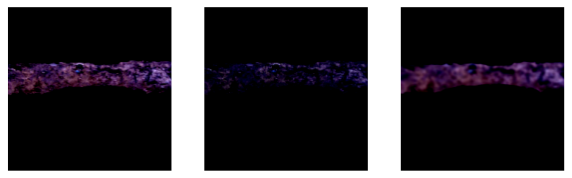

In [43]:
# Check an augmented subset
aug_images = []
for i in range(len(train_dataset)):
    image, tabular_features, label = train_dataset[i]
    aug_images.append(image)
    print(f"Image {i}: Tabular Features {tabular_features.tolist()} | Label {label.item()}")
    if i == 2: break

plt.figure(figsize=(10, 8))
for i in range(len(aug_images)):
    plt.subplot(1, 3, i+1)
    plt.imshow(aug_images[i].swapaxes(0,2).swapaxes(0,1)) # returned shape is (c, h, w)
    plt.axis('off')

In [44]:
val_dataset = bgr_data.ImageTabularDataset(dataframe=val_df,#[:100],
                                            normalize=normalize,
                                            image_path='file',
                                            label=target,
                                            feature_columns=feature_columns)

# Erstelle den DataLoader
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=16)

In [45]:
model.train()
epochs = 30
lr_history, train_loss_history, val_loss_history = [], [], []
train_acc_history, train_topk_acc_history, val_acc_history, val_topk_acc_history = [], [], [], []
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    # Training loop
    train_correct = 0
    train_topk_correct = 0
    train_loss_total = 0
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
    for batch in train_loader_tqdm:
        images, tabular_features, labels = batch
        images, tabular_features, labels = images.to(device), tabular_features.to(device), labels.to(device)
        optimizer.zero_grad() # otherwise, PyTorch accumulates the gradients during backprop
        outputs = model(image=images, tabular_features=tabular_features)
        train_loss = criterion(outputs, labels)
        train_loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Calculate accuracy for this batch
        train_loss_total += train_loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        train_topk_correct += top_k_accuracy(outputs, labels, k=5)

        train_loader_tqdm.set_postfix(loss=train_loss.item())

    # Calculate average training accuracy for the epoch
    train_acc = train_correct / len(train_loader.dataset)
    train_topk_acc = train_topk_correct / len(train_loader)
    avg_train_loss = train_loss_total / len(train_loader)

    # Evaluation loop
    model.eval()
    val_correct = 0
    val_topk_correct = 0
    val_loss_total = 0
    val_loader_tqdm = tqdm(val_loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for batch in val_loader_tqdm:
            images, tabular_features, labels = batch
            images, tabular_features, labels = images.to(device), tabular_features.to(device), labels.to(device)
            outputs = model(image=images, tabular_features=tabular_features)
            val_loss = criterion(outputs, labels)

            val_loss_total += val_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_topk_correct += top_k_accuracy(outputs, labels, k=5)

    # Calculate average val accuracy for the epoch
    val_acc = val_correct / len(val_loader.dataset)
    val_topk_acc = val_topk_correct / len(val_loader)
    avg_val_loss = val_loss_total / len(val_loader)

    # Apply the scheduler with validation loss
    scheduler.step(avg_val_loss)
    # Log the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    lr_history.append(current_lr)
    # Log metrics
    train_loss_history.append(avg_train_loss); val_loss_history.append(avg_val_loss)
    train_acc_history.append(train_acc); val_acc_history.append(val_acc)
    train_topk_acc_history.append(train_topk_acc); val_topk_acc_history.append(val_topk_acc)

    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.4f}, Training Top {criterion.k} Accuracy: {train_topk_acc:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, Validation Top {criterion.k} Accuracy: {val_topk_acc:.4f}")
    print(f"Current LR: {current_lr}")

    # Early stopping check
    early_stopping(val_loss)
    if early_stopping.should_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 1/30


Epoch 1, Training Loss: 1.4939, Training Accuracy: 0.0841, Training Top 5 Accuracy: 0.1982
Validation Loss: 1.4901, Validation Accuracy: 0.1456, Validation Top 5 Accuracy: 0.3027
Current LR: 0.001
Epoch 2/30


Epoch 2, Training Loss: 1.6072, Training Accuracy: 0.0676, Training Top 5 Accuracy: 0.2357
Validation Loss: 1.5317, Validation Accuracy: 0.0665, Validation Top 5 Accuracy: 0.2179
Current LR: 0.001
EarlyStopping: No improvement for 1 epochs.
Epoch 3/30


Epoch 3, Training Loss: 1.5214, Training Accuracy: 0.0672, Training Top 5 Accuracy: 0.2233
Validation Loss: 1.5439, Validation Accuracy: 0.0696, Validation Top 5 Accuracy: 0.2217
Current LR: 0.001
EarlyStopping: No improvement for 2 epochs.
Epoch 4/30


Epoch 4, Training Loss: 1.5309, Training Accuracy: 0.0855, Training Top 5 Accuracy: 0.2136
Validation Loss: 1.4621, Validation Accuracy: 0.0696, Validation Top 5 Accuracy: 0.2244
Current LR: 0.001
EarlyStopping: No improvement for 3 epochs.
Epoch 5/30


Epoch     5: reducing learning rate of group 0 to 1.0000e-04.
Epoch 5, Training Loss: 1.4675, Training Accuracy: 0.0926, Training Top 5 Accuracy: 0.2335
Validation Loss: 1.4489, Validation Accuracy: 0.1329, Validation Top 5 Accuracy: 0.3383
Current LR: 0.0001
EarlyStopping: No improvement for 4 epochs.
Epoch 6/30


Epoch 6, Training Loss: 1.3502, Training Accuracy: 0.1693, Training Top 5 Accuracy: 0.3559
Validation Loss: 1.3732, Validation Accuracy: 0.1456, Validation Top 5 Accuracy: 0.3523
Current LR: 0.0001
EarlyStopping: No improvement for 5 epochs.
Epoch 7/30


Epoch 7, Training Loss: 1.3013, Training Accuracy: 0.1788, Training Top 5 Accuracy: 0.3655
Validation Loss: 1.3304, Validation Accuracy: 0.1551, Validation Top 5 Accuracy: 0.3596
Current LR: 0.0001
Epoch 8/30


Epoch 8, Training Loss: 1.2802, Training Accuracy: 0.1890, Training Top 5 Accuracy: 0.3726
Validation Loss: 1.3292, Validation Accuracy: 0.1614, Validation Top 5 Accuracy: 0.3804
Current LR: 0.0001
EarlyStopping: No improvement for 1 epochs.
Epoch 9/30


Epoch 9, Training Loss: 1.2523, Training Accuracy: 0.1929, Training Top 5 Accuracy: 0.3733
Validation Loss: 1.3016, Validation Accuracy: 0.1804, Validation Top 5 Accuracy: 0.3763
Current LR: 0.0001
Epoch 10/30


Epoch 10, Training Loss: 1.2110, Training Accuracy: 0.1968, Training Top 5 Accuracy: 0.3737
Validation Loss: 1.4593, Validation Accuracy: 0.1392, Validation Top 5 Accuracy: 0.3475
Current LR: 0.0001
EarlyStopping: No improvement for 1 epochs.
Epoch 11/30


Epoch    11: reducing learning rate of group 0 to 1.0000e-05.
Epoch 11, Training Loss: 1.2012, Training Accuracy: 0.1985, Training Top 5 Accuracy: 0.3738
Validation Loss: 1.4065, Validation Accuracy: 0.1424, Validation Top 5 Accuracy: 0.3829
Current LR: 1e-05
EarlyStopping: No improvement for 2 epochs.
Epoch 12/30


Epoch 12, Training Loss: 1.1493, Training Accuracy: 0.2073, Training Top 5 Accuracy: 0.3785
Validation Loss: 1.3242, Validation Accuracy: 0.1804, Validation Top 5 Accuracy: 0.3823
Current LR: 1e-05
EarlyStopping: No improvement for 3 epochs.
Epoch 13/30


Epoch 13, Training Loss: 1.1029, Training Accuracy: 0.2140, Training Top 5 Accuracy: 0.3829
Validation Loss: 1.3025, Validation Accuracy: 0.1677, Validation Top 5 Accuracy: 0.3760
Current LR: 1e-05
EarlyStopping: No improvement for 4 epochs.
Epoch 14/30


Epoch 14, Training Loss: 1.1138, Training Accuracy: 0.2207, Training Top 5 Accuracy: 0.3804
Validation Loss: 1.2774, Validation Accuracy: 0.1741, Validation Top 5 Accuracy: 0.3763
Current LR: 1e-05
EarlyStopping: No improvement for 5 epochs.
Epoch 15/30


Epoch 15, Training Loss: 1.0915, Training Accuracy: 0.2193, Training Top 5 Accuracy: 0.3837
Validation Loss: 1.3378, Validation Accuracy: 0.1677, Validation Top 5 Accuracy: 0.3798
Current LR: 1e-05
EarlyStopping: No improvement for 6 epochs.
Epoch 16/30


Epoch 16, Training Loss: 1.1118, Training Accuracy: 0.2189, Training Top 5 Accuracy: 0.3869
Validation Loss: 1.3167, Validation Accuracy: 0.1709, Validation Top 5 Accuracy: 0.3881
Current LR: 1e-05
EarlyStopping: No improvement for 7 epochs.
Epoch 17/30


Epoch 17, Training Loss: 1.0829, Training Accuracy: 0.2182, Training Top 5 Accuracy: 0.3842
Validation Loss: 1.2435, Validation Accuracy: 0.1709, Validation Top 5 Accuracy: 0.3742
Current LR: 1e-05
EarlyStopping: No improvement for 8 epochs.
Epoch 18/30


Epoch 18, Training Loss: 1.0575, Training Accuracy: 0.2242, Training Top 5 Accuracy: 0.3855
Validation Loss: 1.2847, Validation Accuracy: 0.1646, Validation Top 5 Accuracy: 0.3738
Current LR: 1e-05
Epoch 19/30


Epoch 19, Training Loss: 1.0543, Training Accuracy: 0.2246, Training Top 5 Accuracy: 0.3900
Validation Loss: 1.2383, Validation Accuracy: 0.1677, Validation Top 5 Accuracy: 0.3802
Current LR: 1e-05
EarlyStopping: No improvement for 1 epochs.
Epoch 20/30


Epoch 20, Training Loss: 1.0806, Training Accuracy: 0.2270, Training Top 5 Accuracy: 0.3965
Validation Loss: 1.3273, Validation Accuracy: 0.1741, Validation Top 5 Accuracy: 0.3981
Current LR: 1e-05
EarlyStopping: No improvement for 2 epochs.
Epoch 21/30


Epoch 21, Training Loss: 1.0821, Training Accuracy: 0.2309, Training Top 5 Accuracy: 0.3999
Validation Loss: 1.2645, Validation Accuracy: 0.1709, Validation Top 5 Accuracy: 0.4050
Current LR: 1e-05
EarlyStopping: No improvement for 3 epochs.
Epoch 22/30


Epoch 22, Training Loss: 1.0387, Training Accuracy: 0.2365, Training Top 5 Accuracy: 0.4052
Validation Loss: 1.2051, Validation Accuracy: 0.1867, Validation Top 5 Accuracy: 0.3904
Current LR: 1e-05
EarlyStopping: No improvement for 4 epochs.
Epoch 23/30


Epoch 23, Training Loss: 1.0430, Training Accuracy: 0.2372, Training Top 5 Accuracy: 0.4114
Validation Loss: 1.1785, Validation Accuracy: 0.1835, Validation Top 5 Accuracy: 0.3885
Current LR: 1e-05
Epoch 24/30


Epoch 24, Training Loss: 1.0480, Training Accuracy: 0.2439, Training Top 5 Accuracy: 0.4197
Validation Loss: 1.1508, Validation Accuracy: 0.1994, Validation Top 5 Accuracy: 0.3965
Current LR: 1e-05
EarlyStopping: No improvement for 1 epochs.
Epoch 25/30


Epoch 25, Training Loss: 1.0115, Training Accuracy: 0.2541, Training Top 5 Accuracy: 0.4231
Validation Loss: 1.1451, Validation Accuracy: 0.2120, Validation Top 5 Accuracy: 0.3956
Current LR: 1e-05
Epoch 26/30


Epoch 26, Training Loss: 1.0294, Training Accuracy: 0.2552, Training Top 5 Accuracy: 0.4276
Validation Loss: 1.1717, Validation Accuracy: 0.2310, Validation Top 5 Accuracy: 0.4077
Current LR: 1e-05
Epoch 27/30


Epoch 27, Training Loss: 1.0455, Training Accuracy: 0.2601, Training Top 5 Accuracy: 0.4356
Validation Loss: 1.1684, Validation Accuracy: 0.2342, Validation Top 5 Accuracy: 0.4213
Current LR: 1e-05
Epoch 28/30


Epoch 28, Training Loss: 1.0177, Training Accuracy: 0.2724, Training Top 5 Accuracy: 0.4422
Validation Loss: 1.1781, Validation Accuracy: 0.2405, Validation Top 5 Accuracy: 0.4267
Current LR: 1e-05
EarlyStopping: No improvement for 1 epochs.
Epoch 29/30


Epoch 29, Training Loss: 0.9939, Training Accuracy: 0.2738, Training Top 5 Accuracy: 0.4395
Validation Loss: 1.0927, Validation Accuracy: 0.2342, Validation Top 5 Accuracy: 0.4046
Current LR: 1e-05
EarlyStopping: No improvement for 2 epochs.
Epoch 30/30


Epoch 30, Training Loss: 0.9653, Training Accuracy: 0.2851, Training Top 5 Accuracy: 0.4429
Validation Loss: 1.1791, Validation Accuracy: 0.2437, Validation Top 5 Accuracy: 0.4344
Current LR: 1e-05
EarlyStopping: No improvement for 3 epochs.


### Evaluation

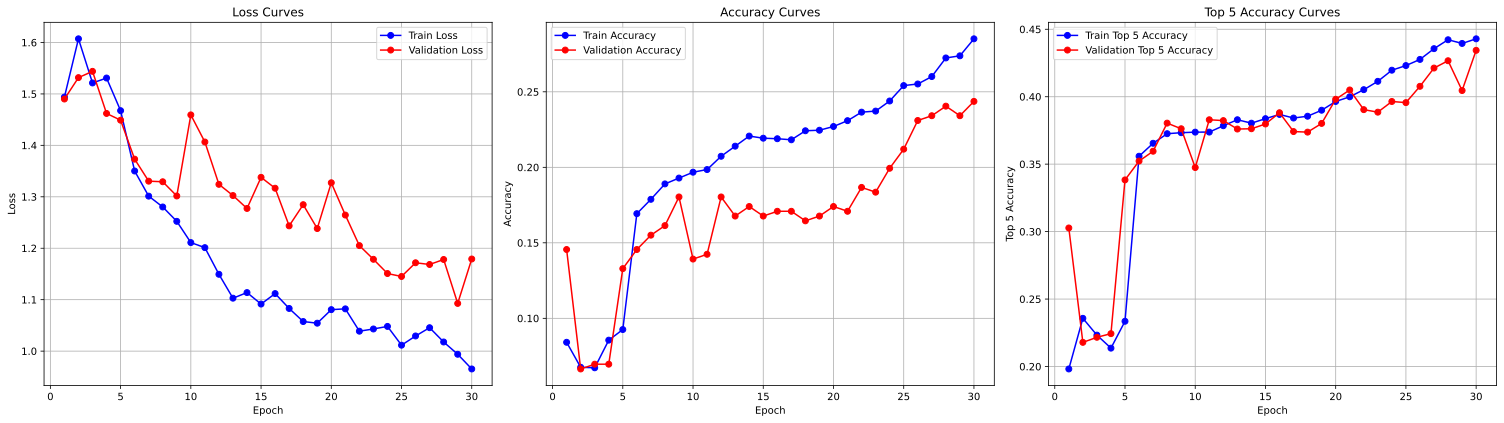

In [46]:
plt.figure(figsize=(21, 6))

complete_epochs = len(train_acc_history)+1
plt.subplot(1, 3, 1)
plt.plot(range(1, complete_epochs), train_loss_history, label='Train Loss', marker='o', color='b')
plt.plot(range(1, complete_epochs), val_loss_history,  label='Validation Loss',  marker='o', color='r')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(range(1, complete_epochs), train_acc_history, label='Train Accuracy', marker='o', color='b')
plt.plot(range(1, complete_epochs), val_acc_history, label='Validation Accuracy', marker='o', color='r')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(range(1, complete_epochs), train_topk_acc_history, label=f'Train Top {criterion.k} Accuracy', marker='o', color='b')
plt.plot(range(1, complete_epochs), val_topk_acc_history, label=f'Validation Top {criterion.k} Accuracy', marker='o', color='r')
plt.title(f'Top {criterion.k} Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel(f'Top {criterion.k} Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

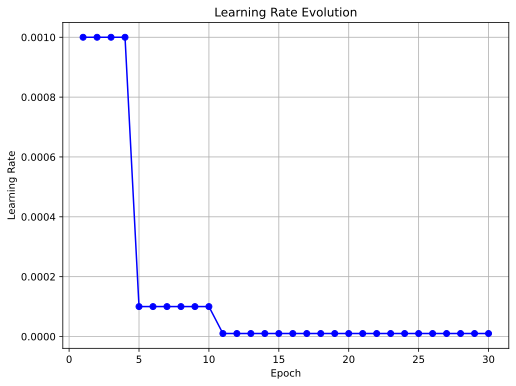

In [47]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, complete_epochs), lr_history, marker='o', linestyle='-', color='b')
plt.title("Learning Rate Evolution")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid()
plt.show()

In [48]:
model.eval()  # Setze das Modell in den Evaluierungsmodus
with torch.no_grad():
    outputs = []
    val_loader_tqdm = tqdm(val_loader, desc="Evaluating", leave=False)
    for batch in val_loader_tqdm:
        images, tabular_features, labels = batch
        images, tabular_features, labels = images.to(device), tabular_features.to(device), labels.to(device)
        outputs.append(model(image=images, tabular_features=tabular_features))

In [49]:
from sklearn.metrics import classification_report, confusion_matrix

# Convert outputs to predicted labels (adjust based on your model's output format)
predicted_probs, predicted_labels = [], []
for output in outputs:

    predicted_labels.extend(torch.argmax(output, dim=1).tolist())
    predicted_probs.extend(torch.softmax(output, dim=1).cpu().numpy()) # Convert logits to probabilities

# Convert true labels to a list
true_labels = [label.item() for batch in val_loader for label in batch[2]]

# Calculate metrics
report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.15      0.42      0.23        50
           1       0.13      0.27      0.17        30
           2       0.06      0.09      0.07        22
           3       0.07      0.19      0.11        21
           4       0.00      0.00      0.00        13
           5       0.00      0.00      0.00        12
           6       0.00      0.00      0.00        12
           7       0.00      0.00      0.00         9
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         8
          10       0.00      0.00      0.00         7
          11       0.00      0.00      0.00         7
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00         7
          14       0.00      0.00      0.00         7
          15       0.00      0.00      0.00         7
          16       0.00      0.00      0.00         6
          17       0.00    

/home/tchiaburu/anaconda3/envs/torch_gpu_sam/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tchiaburu/anaconda3/envs/torch_gpu_sam/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tchiaburu/anaconda3/envs/torch_gpu_sam/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [50]:
# Compute PR curve for each class
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

predicted_probs = np.array(predicted_probs)
true_labels = np.array(true_labels)
n_classes = predicted_probs.shape[1]
precision, recall, avg_precision = {}, {}, {}
# Binarize the labels (one-hot encoding for multiclass)
true_labels_binarized = label_binarize(true_labels, classes=np.arange(n_classes))

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(true_labels_binarized[:, i], predicted_probs[:, i])
    avg_precision[i] = average_precision_score(true_labels_binarized[:, i], predicted_probs[:, i])

# Compute macro-average PR curve
precision["macro"], recall["macro"], _ = precision_recall_curve(true_labels_binarized.ravel(), predicted_probs.ravel())
avg_precision["macro"] = average_precision_score(true_labels_binarized, predicted_probs, average="macro")

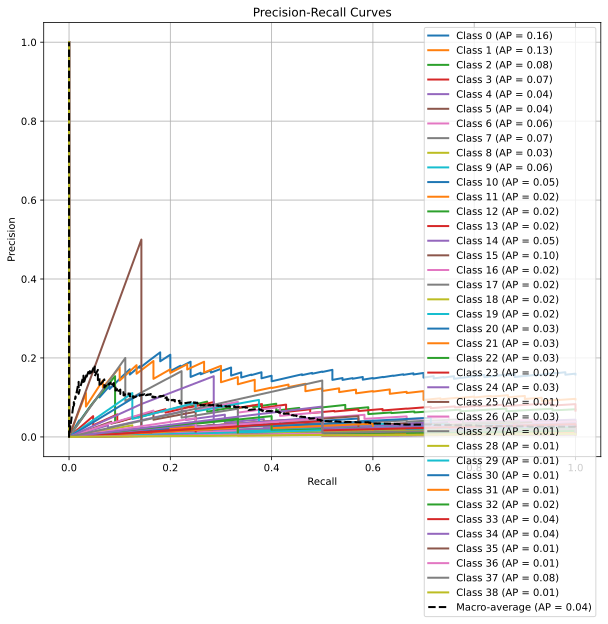

In [51]:
plt.figure(figsize=(10, 8))

# Plot PR curves for each class
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AP = {avg_precision[i]:.2f})')

# Plot macro-average PR curve
plt.plot(recall["macro"], precision["macro"], linestyle='--', lw=2, color='black',
         label=f'Macro-average (AP = {avg_precision["macro"]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='upper right')
plt.grid()
plt.show()

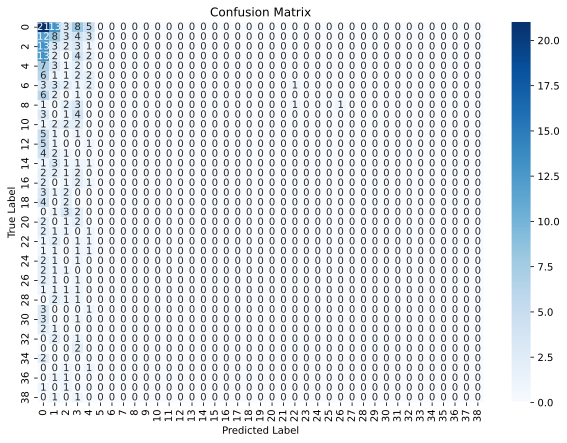

In [52]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [53]:
"""
# TODO
from transformers import TrainingArguments, Trainer

# Define training arguments
training_args = TrainingArguments(
    output_dir="./testtest",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    num_train_epochs=53,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=1000,
    learning_rate=5e-5,
    weight_decay=0.01,
    report_to="none",  # Set to "wandb" or other service if tracking experiments
)

# Initialize the Trainer with the model, data, and training arguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=collate_fn,
)

# Train the model
trainer.train()

# Evaluate the model on the test dataset
eval_results = trainer.evaluate()
print(f"Test Accuracy: {eval_results['eval_accuracy']}")
"""

'\n# TODO\nfrom transformers import TrainingArguments, Trainer\n\n# Define training arguments\ntraining_args = TrainingArguments(\n    output_dir="./testtest",\n    per_device_train_batch_size=32,\n    per_device_eval_batch_size=32,\n    evaluation_strategy="epoch",\n    num_train_epochs=53,\n    logging_dir="./logs",\n    logging_steps=10,\n    save_steps=1000,\n    learning_rate=5e-5,\n    weight_decay=0.01,\n    report_to="none",  # Set to "wandb" or other service if tracking experiments\n)\n\n# Initialize the Trainer with the model, data, and training arguments\ntrainer = Trainer(\n    model=model,\n    args=training_args,\n    train_dataset=train_dataset,\n    eval_dataset=test_dataset,\n    data_collator=collate_fn,\n)\n\n# Train the model\ntrainer.train()\n\n# Evaluate the model on the test dataset\neval_results = trainer.evaluate()\nprint(f"Test Accuracy: {eval_results[\'eval_accuracy\']}")\n'